# Damped-Local-Trend(DLT) Example

In [1]:
import pandas as pd
import numpy as np
from orbit.dlt import DLT
from orbit.utils.utils import plot_predicted_data

## Data

In [2]:
DATA_FILE = "./data/iclaims.example.csv"

In [3]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [4]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

### Data Transformation

In [5]:
df=raw_df.copy()
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log, axis=1)
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


### Train / Test Split

In [6]:
test_size=52
train_df=df[:-test_size]

# in uTS we make assertion that test dates need to be between train start/end
test_df=df[-test_size:]

## MAP Fit and Predict

In [7]:
dlt_map=DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [8]:
dlt_map.fit(df=train_df)

In [9]:
dlt_map.aggregated_posteriors

{'mean': None,
 'median': None,
 'map': {'l': array([[13.91721278, 13.91710301, 13.91883923, 13.91755996, 13.92050022,
          13.92288525, 13.92467963, 13.92798631, 13.93185834, 13.93160309,
          13.93271913, 13.93305024, 13.93271572, 13.93370174, 13.93352472,
          13.9312205 , 13.92876132, 13.92754589, 13.92543672, 13.92600444,
          13.92473226, 13.92356706, 13.92258178, 13.92256958, 13.92124674,
          13.92120273, 13.92249326, 13.92235751, 13.9215267 , 13.92348865,
          13.92748239, 13.93132547, 13.93277604, 13.93167221, 13.93091176,
          13.92891319, 13.92468743, 13.92261923, 13.92276761, 13.92238598,
          13.92232636, 13.91887448, 13.91608267, 13.91560751, 13.91492382,
          13.91329904, 13.91009666, 13.90805888, 13.90746017, 13.9063091 ,
          13.90695004, 13.90347575, 13.90478622, 13.9128603 , 13.90504618,
          13.91575703, 13.91267822, 13.90972486, 13.91038175, 13.90416686,
          13.88480551, 13.88915637, 13.88822441, 13.8890

In [10]:
predicted_df = dlt_map.predict(df=test_df)

In [11]:
predicted_df.head(5)

,week,prediction
0,2017-07-02,12.425010
1,2017-07-09,12.545258
2,2017-07-16,12.382638
3,2017-07-23,12.236157
4,2017-07-30,12.189419


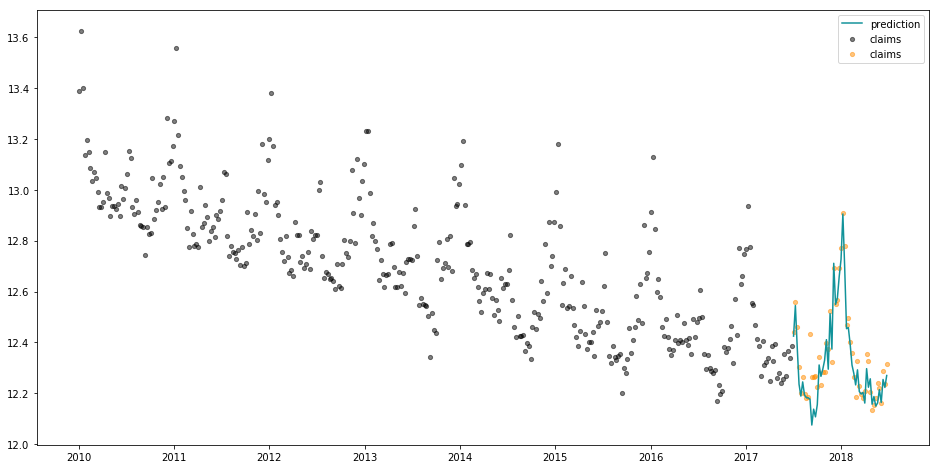

In [12]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_map.date_col, actual_col=dlt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MCMC Fit and Predict

In [13]:
dlt_mcmc = DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    sample_method='mcmc',
    predict_method='full',
    n_bootstrap_draws=500
)

In [14]:
dlt_mcmc.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [15]:
predicted_df = dlt_mcmc.predict(df=test_df)

In [16]:
predicted_df.tail(5)

,week,5,50,95
47,2018-05-27,12.110288,12.229368,12.364568
48,2018-06-03,12.033952,12.175719,12.295327
49,2018-06-10,12.146923,12.271813,12.374391
50,2018-06-17,12.109927,12.233728,12.348772
51,2018-06-24,12.156287,12.277996,12.395726


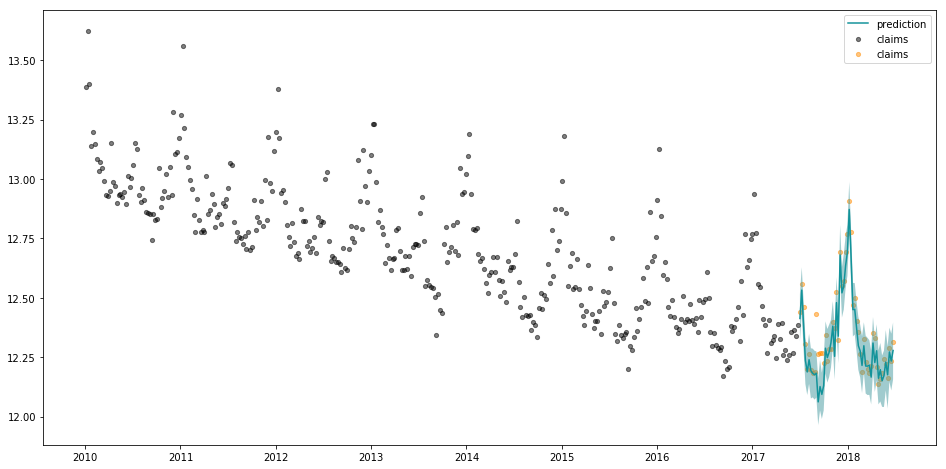

In [17]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_mcmc.date_col, actual_col=dlt_mcmc.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Mean Fit and Predict Decomp

In [19]:
dlt_mean=DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='mean'
)

In [20]:
dlt_mean.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [21]:
predicted_df = dlt_mean.predict(df=test_df, decompose=True)

In [22]:
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.411933,12.356740,0.055193,0.0
1,2017-07-09,12.529896,12.354807,0.175088,0.0
2,2017-07-16,12.379711,12.352866,0.026845,0.0
3,2017-07-23,12.233765,12.350917,-0.117152,0.0
4,2017-07-30,12.184009,12.348961,-0.164952,0.0


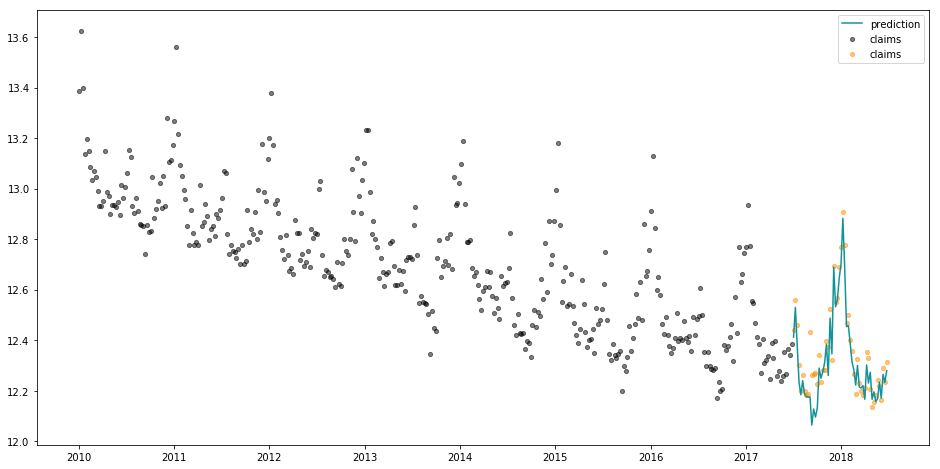

In [23]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_mean.date_col, actual_col=dlt_mean.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MAP Fit and Decomp with Regression

In [25]:
dlt_reg=DLT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [26]:
dlt_reg.fit(df=train_df)

In [27]:
predicted_df = dlt_reg.predict(df=test_df, decompose=True)

In [28]:
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.505556,12.345227,0.145249,0.015080
1,2017-07-09,12.551643,12.347274,0.208015,-0.003646
2,2017-07-16,12.331489,12.349321,-0.025970,0.008138
3,2017-07-23,12.217590,12.351368,-0.133922,0.000144
4,2017-07-30,12.230607,12.353415,-0.126598,0.003789
